core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
c:\Users\dilau\Desktop\TeamProjF1\fasftF1\.venv\Lib\site-pack

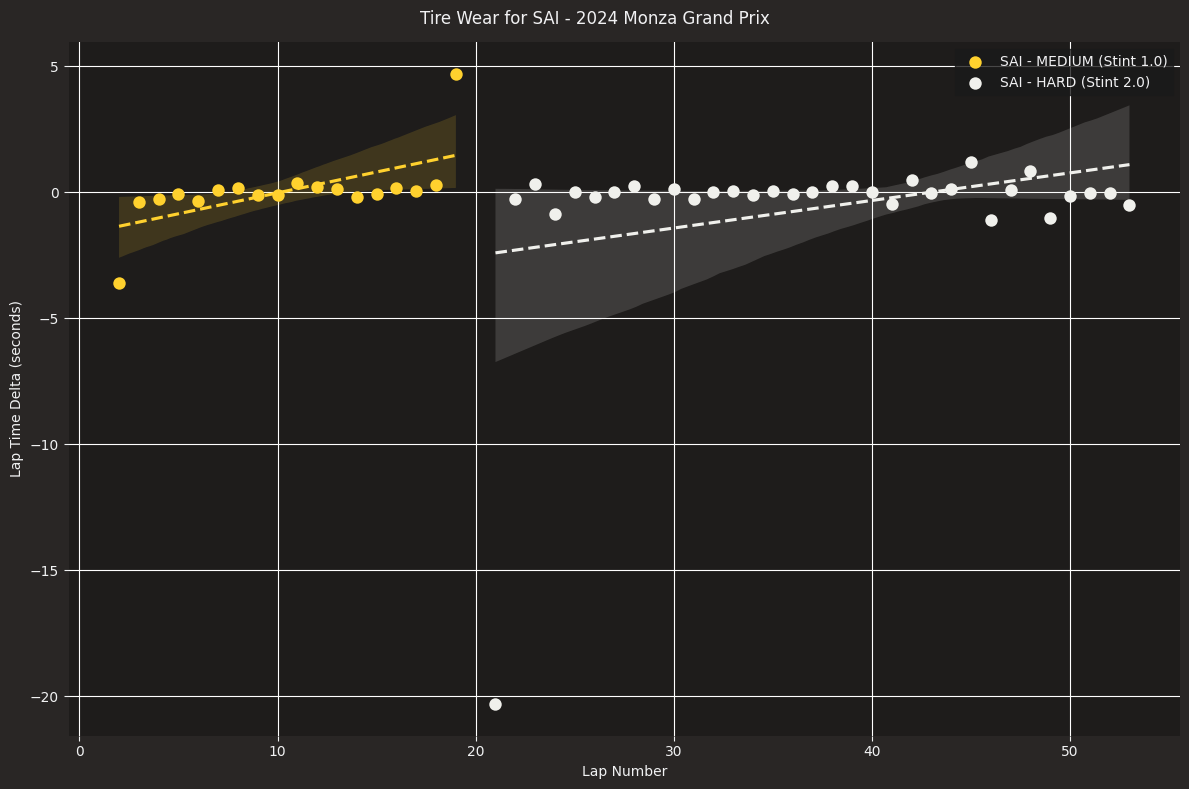

In [7]:
import seaborn as sns
import fastf1
import fastf1.plotting
from matplotlib import pyplot as plt

# Enable cache to speed up data loading (optional)
# fastf1.Cache.enable_cache('cache')

# Set up FastF1 and Matplotlib for better-looking plots
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False, color_scheme='fastf1')

# Define the session details
year = 2024
gran_prix = "Monza"
sessionG = 'R'  # Race session
driver = "SAI"  # Driver to analyze

# Load the race session
session = fastf1.get_session(year, gran_prix, sessionG)
session.load()  # Fetch the data for the session

# Get all laps for the specified driver
driver_laps = session.laps.pick_driver(driver).reset_index()

# Get the list of unique tire compounds used by the driver
compounds_used = driver_laps["Compound"].unique()

# Get all laps for the specified driver and tire compound
stint_compounds = driver_laps.groupby(["Stint", "Compound"]).size().reset_index(name="LapCount")

# Check if there is any data to plot
if len(compounds_used) == 0:
    print(f"No data found for {driver}.")
else:
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

     # Loop through each compound used by the driver
    for compound in compounds_used:
        # Filter laps for the current compound
        compound_laps = driver_laps[driver_laps["Compound"] == compound]

        # Group laps by stint (each stint is a continuous period on the same set of tires)
        for stint, stint_laps in compound_laps.groupby("Stint"):
            # Calculate lap time deltas (difference between consecutive laps)
            stint_laps["LapTimeDelta"] = stint_laps["LapTime"].diff().dt.total_seconds()

            # Remove the first row (no delta for the first lap)
            stint_laps = stint_laps.dropna(subset=["LapTimeDelta"])

            # Plot lap time deltas for the current stint
            sns.scatterplot(
                data=stint_laps,
                x="LapNumber",  # Lap number on the x-axis
                y="LapTimeDelta",  # Lap time delta on the y-axis
                ax=ax,
                color=fastf1.plotting.get_compound_color(compound, session=session),  # Use compound color
                s=80,  # Marker size
                linewidth=0,
                label=f"{driver} - {compound} (Stint {stint})"  # Label for the legend
            )

            # Add a trendline for the current stint to visualize tire wear
            sns.regplot(
                data=stint_laps,
                x="LapNumber",
                y="LapTimeDelta",
                ax=ax,
                scatter=False,  # Don't plot scatter points for the trendline
                color=fastf1.plotting.get_compound_color(compound, session=session),  # Trendline color
                line_kws={"linestyle": "--", "label": f"Stint {stint} Trendline"}  # Trendline style and label
            )

    # Customize the plot
    ax.set_xlabel("Lap Number")  # Label for the x-axis
    ax.set_ylabel("Lap Time Delta (seconds)")  # Label for the y-axis
    plt.suptitle(f"Tire Wear for {driver} - {year} {gran_prix} Grand Prix")  # Plot title

    # Add grid and improve layout
    plt.grid(color='w', which='major', axis='both')  # Add a white grid
    sns.despine(left=True, bottom=True)  # Remove unnecessary borders
    plt.tight_layout()  # Adjust layout to prevent overlapping

    # Show the plot
    plt.show()